Epoch 10/200, Loss: 1.5702
Epoch 20/200, Loss: 1.5539
Epoch 30/200, Loss: 1.5493
Epoch 40/200, Loss: 1.5466
Epoch 50/200, Loss: 1.5452
Epoch 60/200, Loss: 1.5448
Epoch 70/200, Loss: 1.5428
Epoch 80/200, Loss: 1.5419
Epoch 90/200, Loss: 1.5422
Epoch 100/200, Loss: 1.5405
Epoch 110/200, Loss: 1.5403
Epoch 120/200, Loss: 1.5399
Epoch 130/200, Loss: 1.5397
Epoch 140/200, Loss: 1.5389
Epoch 150/200, Loss: 1.5385
Epoch 160/200, Loss: 1.5388
Epoch 170/200, Loss: 1.5386
Epoch 180/200, Loss: 1.5382
Epoch 190/200, Loss: 1.5394
Epoch 200/200, Loss: 1.5388


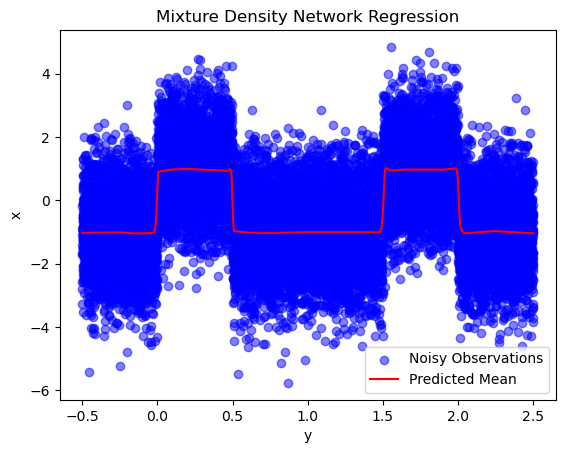

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Generate data
n_samples = 20000
y = np.random.uniform(-.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

# Apply conditions to generate xtrue based on y
for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = np.random.normal(1, scale=0.5 )
    else:
        xtrue[i] = np.random.normal(-1, scale=0.5 )

# Generate x and s (noisy observations)
x = xtrue + np.random.normal(0, 1, len(xtrue))

# Standardize the input y
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define dataset class
class DensityRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Mixture Density Network
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.pi = nn.Linear(hidden_dim, n_gaussians)  # Mixing coefficients (weights)
        self.mu = nn.Linear(hidden_dim, n_gaussians)  # Means of Gaussians
        self.log_sigma = nn.Linear(hidden_dim, n_gaussians)  # Log of standard deviations

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        pi = torch.softmax(self.pi(x), dim=1)  # Softmax for mixture weights
        mu = self.mu(x)  # Mean of each Gaussian
        log_sigma = self.log_sigma(x)  # Log standard deviation for stability
        return pi, mu, log_sigma

# Negative log-likelihood loss for Mixture Density Networks
def mdn_loss(pi, mu, log_sigma, y):
    sigma = torch.exp(log_sigma)
    m = torch.distributions.Normal(mu, sigma)
    probs = m.log_prob(y.unsqueeze(1))  # Log probability of y under each Gaussian
    log_probs = probs + torch.log(pi + 1e-8)  # Log-prob weighted by pi
    nll = -torch.logsumexp(log_probs, dim=1)  # Logsumexp for numerical stability
    return nll.mean()

# Create dataset and dataloader
dataset = DensityRegressionDataset(X_scaled, x)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model, optimizer, and loss function
n_gaussians = 5  # Number of Gaussians in the mixture
model = MDN(input_dim=1, hidden_dim=64, n_gaussians=n_gaussians)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        pi, mu, log_sigma = model(inputs)
        loss = mdn_loss(pi, mu, log_sigma, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(dataloader):.4f}')

# Generate predictions for plotting
model.eval()
with torch.no_grad():
    y_test = np.linspace(-0.5, 2.5, 1000).reshape(-1, 1)
    y_test_scaled = scaler.transform(y_test)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    pi, mu, log_sigma = model(y_test_tensor)
    # Choose mean of Gaussian with highest weight for visualization
    pi = pi.numpy()
    mu = mu.numpy()
    pred_mean = np.sum(pi * mu, axis=1)  # Weighted sum of means

# Plot the results
plt.scatter(y, x, c='blue', label='Noisy Observations', alpha=0.5)
plt.plot(y_test, pred_mean, color='red', label='Predicted Mean')
plt.title('Mixture Density Network Regression')
plt.xlabel('y')
plt.ylabel('x')
plt.legend()
plt.show()


In [11]:
# After training, we can compute the posterior mean for new observations:

# Generate predictions for computing posterior means
model.eval()
with torch.no_grad():
    # Test input (for example, 1000 points evenly spaced between -0.5 and 2.5)
    y_test = np.linspace(-0.5, 2.5, 1000).reshape(-1, 1)
    y_test_scaled = scaler.transform(y_test)  # Standardize the test input
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Get the mixture parameters from the MDN model
    pi, mu, log_sigma = model(y_test_tensor)

    # Compute the posterior mean as the weighted sum of the Gaussian means
    pi = pi.numpy()  # Convert from tensor to numpy
    mu = mu.numpy()  # Convert from tensor to numpy
    posterior_mean = np.sum(pi * mu, axis=1)  # Weighted sum of means


In [17]:
pi

array([[4.6035631e-19, 1.1384364e-19, 1.6163252e-09, 8.1440514e-12,
        1.0000000e+00],
       [5.9354722e-19, 1.4968689e-19, 1.8249597e-09, 9.4880579e-12,
        1.0000000e+00],
       [7.6527317e-19, 1.9681676e-19, 2.0605286e-09, 1.1053886e-11,
        1.0000000e+00],
       ...,
       [2.2366699e-24, 8.4795893e-28, 2.5631765e-20, 6.1091848e-19,
        1.0000000e+00],
       [1.6339126e-24, 5.8854147e-28, 1.9916856e-20, 4.8375218e-19,
        1.0000000e+00],
       [1.1936188e-24, 4.0849273e-28, 1.5476275e-20, 3.8306065e-19,
        1.0000000e+00]], dtype=float32)

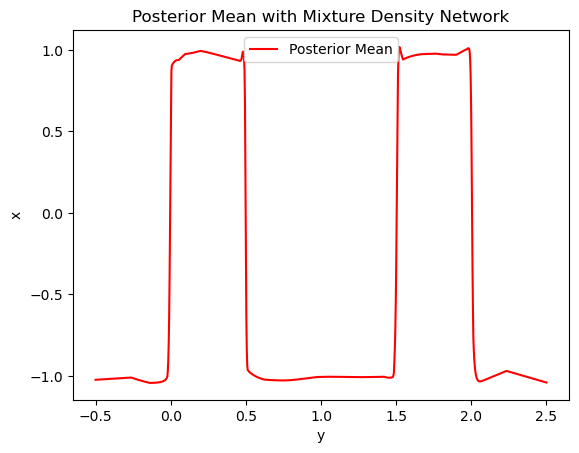

In [14]:
# Plot the posterior mean
plt.scatter(y, x, c='blue', label='Noisy Observations', alpha=0.5)
plt.plot(y_test, posterior_mean, color='red', label='Posterior Mean')
plt.title('Posterior Mean with Mixture Density Network')
plt.xlabel('y')
plt.ylabel('x')
plt.legend()
plt.show()
